In [1]:
import pandas as pd
import numpy as np
from pymoo.algorithms.nsga3 import NSGA3
from pymoo.algorithms.rnsga2 import RNSGA2
from pymoo.algorithms.rnsga3 import RNSGA3
from pymoo.algorithms.unsga3 import UNSGA3
from pymoo.factory import get_reference_directions
from pymoo.optimize import minimize
import pickle

from pymoo.util.termination.f_tol import MultiObjectiveSpaceToleranceTermination

from notebooks.optimization_problems.constraints import Requirements
from optimization_problems.biased_initialization import max_contact_biased
%load_ext autoreload

%autoreload 2

In [2]:
prefix = 'iot_' + 'o3b_'

case, target = pickle.load(open('raw/%ssettings.pkl' % prefix, 'rb'))

import util
util.print_targets(case)

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!
Targets per orbit
T_target: 20.00 Gb (min: 20.00 Gb, max: -0.00 Gb)
L_target: 60.00 s
E_target: 16.82 kJ (max: -0.00 kJ)
P_target: 0.00 s


In [3]:
columns = ['strand_name', 'tof',
           'r_a_x', 'r_a_y', 'r_a_z',
           'v_a_x', 'v_a_y', 'v_a_z',
           'r_b_x', 'r_b_y', 'r_b_z',
           'd',
           'r_ab_sff_x', 'r_ab_sff_y', 'r_ab_sff_z']

file_path = "raw/%spost_processed.h5" % prefix

row_limit = -1

store = pd.HDFStore(file_path)

instances_df = store.select('contact_instances', 'columns = %s' % str(columns), stop = row_limit)

# Sort by pass id
instances_df = instances_df.sort_index(0)

In [4]:
from notebooks.optimization_problems.design_vector import design_vector_default_scm, SystemParameters

sys_param = SystemParameters()
sys_param.fc_Hz = target['frequency']
sys_param.GT_dBK = target['GT_dBK']
sys_param.margin_dB = 3.0
sys_param.B_Hz_array = np.array([0.1, 0.5, 1, 10, 50, 100, 200, 300]) * 1e6
sys_param.Gtx_dBi_bounds = (3., 50.)
sys_param.Ptx_dBm_bounds = (20., 43.)

modcods_df = pd.read_pickle('../dvbs2.pkl')

sys_param.EsN0_req_dB_array = modcods_df[['isend', 'isend_200MHz', 'isend_300MHz']].to_numpy()
sys_param.eta_bitsym_array = modcods_df[['eta', 'eta_200MHz', 'eta_300MHz']].to_numpy()
sys_param.eta_maee_array = modcods_df[['maee_12', 'maee_12_200MHz', 'maee_12_300MHz']].to_numpy()

requirements = case['requirements']
#requirements.max_throughput = -1

### Problem definition
Defines a ExtendandCombinedProblem

In [5]:
from combined_problem import ExtendedCombinedProblem
problem = ExtendedCombinedProblem(instances_df, sys_param, requirements=requirements, f_mask=np.array([1, 2, 3]))
sampling, crossover, mutation = design_vector_default_scm(problem.x_length, problem.x_indices)

Algorithm settings

Generating biased initial population
init_ref_dirs: 400
init_pop_size: 400
init_n_offsprings: 100
Running initial conditions optimization...
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |     400 |       1 |            - |            -
    2 |     500 |       4 |  1.000000000 |        ideal
    3 |     600 |       4 |  0.011487603 |            f
    4 |     700 |       4 |  0.00000E+00 |            f
    5 |     800 |       5 |  0.270028958 |        ideal
    6 |     900 |       5 |  0.049951737 |            f
    7 |    1000 |       5 |  0.00000E+00 |            f
    8 |    1100 |       5 |  0.000096525 |            f
    9 |    1200 |       5 |  0.00000E+00 |            f
   10 |    1300 |       5 |  0.00000E+00 |            f
   11 |    1400 |       4 |  0.058181818 |        ideal
   12 |    1500 |       5 |  0.208775400 |        ideal
   13 |    1600 |       5 |  0.00000E+00 |            f
   14 |    1700 |       5 |  0.00000E+00 |            f
   15 |    1800 |  

C:\git\hermes-optimization\cenv\lib\site-packages\pymoo\operators\mutation\polynomial_mutation.py:47: RuntimeWarning: invalid value encountered in power
  d = np.power(val, mut_pow) - 1.0


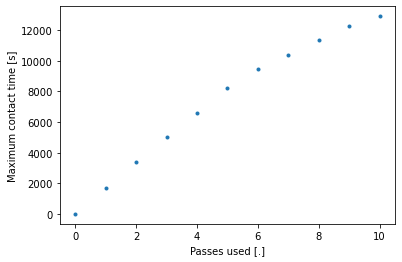

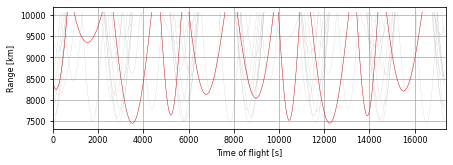

In [6]:
settings = {}

# NSGA-III
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=13)
pop_size=int(np.ceil(len(ref_dirs) / 100) * 100)
n_offsprings=int(np.ceil(len(ref_dirs) / 100) * 100 / 4)

from os import path
file_name = 'raw/%sbiased_inits.pkl' % (prefix)

if path.exists(file_name):
    print("Loaded biased initial population")
    biased_init = pickle.load(open(file_name, 'rb'))
else:
    print("Generating biased initial population")
    biased_init = max_contact_biased(instances_df, sys_param, case, pop_size, init='min')
    pickle.dump(biased_init, open(file_name, 'wb'))

settings['NSGA-III-BIASED'] = {
    'label': 'nsga3',
    'algorithm': NSGA3(
        pop_size=pop_size,
        n_offsprings=n_offsprings,
        sampling=biased_init,
        crossover=crossover,
        mutation=mutation,
        ref_dirs=ref_dirs,
        eliminate_duplicates=True,
    ),
    'desc': 'NSGA 3 biased (ref_dirs=%d, pop_size=%d, n_offsprings=%d)' % (len(ref_dirs), pop_size, n_offsprings),
    'file_label': 'nsga3_biased_%d_%d_%d' % (len(ref_dirs), pop_size, n_offsprings),
    'termination': ""
}

setting = settings['NSGA-III-BIASED']

print("Selected setting: %s" % setting['desc'])

Setting up optimization files

In [7]:
termination = setting['termination']
algorithm = setting['algorithm']

n_gen_inc = 1000

from os import path

file_name = 'raw/%s%s.pkl' % (prefix, setting['file_label'])

if path.exists(file_name):
    print("Loading starting point: %s" % file_name)
    problem, setting, res = pickle.load(open(file_name, 'rb'))
    algorithm = res.algorithm
    algorithm.has_terminated = False
    n_gen = res.algorithm.n_gen
else:
    print("Creating new starting point: %s" % file_name)
    n_gen = 0

Creating new starting point: raw/iot_o3b_nsga3_biased_105_200_50.pkl


In [8]:
n_gen = n_gen + n_gen_inc
print("Maximum number of generations: %d" % n_gen)
termination = ('n_gen', n_gen)

Maximum number of generations: 3000


In [9]:
print("Starting optimization...")

res = minimize(problem,
               algorithm,
               termination,
               #termination=termination,
               seed=1,
               #save_history=True,
               verbose=True,
               copy_algorithm=False,
               )

print('Processes:', res.exec_time)
print("Best solution found: %s" % res.X)

pickle.dump((problem, setting, res), open(file_name, 'wb'))

Starting optimization...
    2 |      61 |  1.000000000 |  1.000000000 |       1 |  0.00000E+00 |            f
    3 |     111 |  1.000000000 |  1.000000000 |       1 |  0.00000E+00 |            f
    4 |     161 |  1.000000000 |  1.000000000 |       1 |  0.00000E+00 |            f
    5 |     211 |  1.000000000 |  1.000000000 |       1 |  0.00000E+00 |            f
    6 |     261 |  1.000000000 |  1.000000000 |       1 |  0.00000E+00 |            f
    7 |     311 |  1.000000000 |  1.000000000 |       1 |  0.00000E+00 |            f
    8 |     361 |  1.000000000 |  1.000000000 |       1 |  0.00000E+00 |            f
    9 |     411 |  1.000000000 |  1.000000000 |       1 |  0.00000E+00 |            f
   10 |     461 |  1.000000000 |  1.000000000 |       1 |  0.00000E+00 |            f
   11 |     511 |  1.000000000 |  1.000000000 |       1 |  0.00000E+00 |            f
   12 |     561 |  1.000000000 |  1.000000000 |       1 |  0.00000E+00 |            f
   13 |     611 |  1.00000000

In [10]:
from beepy import beep
for i in range(3):
    beep(sound=5)
